In [1]:
# header files 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import seaborn as sn

# read all the files in a given folder and return the extracted features
# input : path of the folder in the device
def readImageFeatures(os_path):
    files = os.listdir(os_path)
    features = [np.zeros((36,23)) for file in files]
    for i in range(len(files)):
        image_data = pd.read_csv(os.path.join(os_path,files[i]),sep=" ",header =None)
        features[i] = np.asarray(image_data)
    return features

# reading training datasets from folders of each of the class
os_path = r"dataset\Dataset_2B\forest\train"
feature_train1 = readImageFeatures(os_path)
class_train1 = [0]*len(feature_train1)
os_path = r"dataset\Dataset_2B\highway\train"
feature_train2 = readImageFeatures(os_path)
class_train2 = [1]*len(feature_train2)
os_path = r"dataset\Dataset_2B\insidecity\train"
feature_train3 = readImageFeatures(os_path)
class_train3 = [2]*len(feature_train3)
os_path = r"dataset\Dataset_2B\mountain\train"
feature_train4 = readImageFeatures(os_path)
class_train4 = [3]*len(feature_train4)
os_path = r"dataset\Dataset_2B\street\train"
feature_train5 = readImageFeatures(os_path)
class_train5 = [4]*len(feature_train5)

# concatenating the datasets to form a single dataset
feature_train = np.concatenate([feature_train1,feature_train2,feature_train3,feature_train4,feature_train5])
class_train = np.concatenate([class_train1,class_train2,class_train3,class_train4,class_train5])

# reading devloper datasets from folders of each of the class
os_path = r"dataset\Dataset_2B\forest\dev"
feature_dev1 = readImageFeatures(os_path)
class_dev1 = [0]*len(feature_dev1)
os_path = r"dataset\Dataset_2B\highway\dev"
feature_dev2 = readImageFeatures(os_path)
class_dev2 = [1]*len(feature_dev2)
os_path = r"dataset\Dataset_2B\insidecity\dev"
feature_dev3 = readImageFeatures(os_path)
class_dev3 = [2]*len(feature_dev3)
os_path = r"dataset\Dataset_2B\mountain\dev"
feature_dev4 = readImageFeatures(os_path)
class_dev4 = [3]*len(feature_dev4)
os_path = r"dataset\Dataset_2B\street\dev"
feature_dev5 = readImageFeatures(os_path)
class_dev5 = [4]*len(feature_dev5)

# concatenating the datasets to form a single dataset
dev_dataset = np.concatenate([feature_dev1,feature_dev2,feature_dev3,feature_dev4,feature_dev5])
dev_class = np.concatenate([class_dev1,class_dev2,class_dev3,class_dev4,class_dev5])

class_count = 5
d = len(feature_train[0][0])
t = len(feature_train[0])

# splitting the developer data into validation data and test data
feature_test = [np.zeros((t,d)) for rows in range(int(len(dev_dataset)/2))]
class_test = np.zeros(int(len(dev_dataset)/2))
feature_dev = [np.zeros((t,d)) for rows in range(int((len(dev_dataset)+1)/2))]
class_dev = np.zeros(int((len(dev_dataset)+1)/2))
for i in range(len(dev_dataset)):
    if i%2:
        feature_test[int((i-1)/2)] = dev_dataset[i]
        class_test[int((i-1)/2)] = dev_class[i]
    else:
        feature_dev[int(i/2)] = dev_dataset[i]
        class_dev[int(i/2)] = dev_class[i]

In [2]:
# for printing Heatmap of the confusion matrix
# input : confusion matrix
def printheatmap(c):
    sn.heatmap(c,annot=True,fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show() 

In [3]:
# returns the euclidian distance between 2 points 
# inputs : takes 2 points
def Euclidean_distance(data1,data2):
    return math.sqrt(sum((data1-data2)**2))

In [4]:
# returns gaussian probability that a given data points belongs to a particular class 
# input : the data point to be classfied, mean and covariance vectors of each of the class
def gaussianPrabability(data,mean,cov):
    cov += ((10**(-6))*(np.identity(d))) 
    u = data-mean
    exp = -0.5*(u.transpose().dot(np.linalg.inv(cov)).dot(u)) -(d/2)*np.log(2*math.pi) -0.5*np.log(np.linalg.det(cov))
    return math.e**(exp)

In [5]:
# assign a training example to a cluster depending upon the euclidean distance from the cluster centre
# inputs : cluster centres, training example, no. of clusters
def assignCluster(mean,data,k):
    z = np.zeros((len(data),k))
    for i in range(len(data)):
        closest = Euclidean_distance(data[i],mean[0])**2
        z[i][0] = 1
        for j in range(len(mean)):
            dist = Euclidean_distance(data[i],mean[j])**2
            if(dist < closest):
                closest = dist
                z[i] = np.zeros(k)
                z[i][j] = 1
    return z

In [6]:
# update the mean of the clusters
# inputs : cluster assignment, train data, no. of clusters
def updateMean(z,data,k):
    mean = np.zeros((k,d))
    N = sum(z)
    for i in range(k):
        for j in range(len(data)):
            mean[i]+=data[j]*z[j][i]
        mean[i]/=N[i]
    return mean

In [7]:
# update the cavariance of the clusters
# inputs : cluster assignment, train data, no. of clusters, mean of the clusters
def updateCov(z,data,k,mean):
    N = sum(z)
    cov = [np.zeros((d,d)) for rows in range(k)]
    for i in range(k):
        for j in range(len(data)):
            u = data[j]-mean[i]
            cov[i]+= z[j][i]*np.outer(u,u.transpose())
        cov[i]/=N[i]
    return cov

In [8]:
# K means clustering to find k clusters
# inputs : no. of clusters, train data, max no. of iterations
def KmeansClustering(k,data,iteration):
    mean = np.zeros((k,d))
    mean_index_initial = np.random.choice(len(data),k)    
    for i in range(k):
        mean[i] = data[mean_index_initial[i]]
    z_old = assignCluster(mean,data,k)
    for i in range(iteration):
        mean = updateMean(z_old,data,k)
        z_new = assignCluster(mean,data,k)
        if np.allclose(z_new,z_old):
            break
        z_old = z_new
    return mean

In [9]:
# returns the likelihood that the given example belongs to a particular cluster
# input : no. of clusters, ratio of points in each cluster, datapoints, cluster mean, cluster covariance matrices
def likelihood(k,w,data,mean,cov):
    likelihood = 0
    for i in range(k):
        likelihood += w[i]*gaussianPrabability(data,mean[i],cov[i])
    return likelihood

In [10]:
# returns the total log likelihood that the examples belongs to a particular class
# input : datapoints, no. of clusters, ratio of points in each cluster, cluster mean, cluster covariance matrices
def totalLogLikelihood(data,k,w,mean,cov):
    totalLikelihood = 0
    for i in range(len(data)):
        totalLikelihood += np.log(likelihood(k,w,data[i],mean,cov))
    return totalLikelihood

In [11]:
# assign a training example to a cluster after the algorithm has made changes to maximize likelihood
# inputs : datapoints, no. of clusters, ratio of points in each cluster, cluster centres, training example
def ExpectationStep(data,k,w,mean,cov):
    z = np.zeros((len(data),k))
    for i in range(len(data)):
        denominator = 0
        for j in range(k):
            z[i][j] = w[j]*gaussianPrabability(data[i],mean[j],cov[j])
            denominator+=z[i][j]
        z[i]/=denominator
    return z

In [12]:
# returns the parameters of the Gaussian mixture model for a specific class from that class examples
# inputs : class examples of a class, the number of clusters for that class
def GMM(data,k):
    iteration = 100

    # Initialization of the means and assignment of points in clusters
    mean = KmeansClustering(k,data,iteration)
    gamma_old = assignCluster(mean,data,k)

    # Updating mean, covariance and calculating N (no. of points in each cluster), w (ratio of points in each class)
    N = sum(gamma_old)
    w = N/sum(N)
    mean = updateMean(gamma_old,data,k)
    cov = updateCov(gamma_old,data,k,mean)

    print(N)

    # calculating the total log likelihood
    totalLikelihood_old = totalLogLikelihood(data,k,w,mean,cov) 
    threshold = 0.01

    # Updating the cluster assignment to improve the total log likelihood
    for i in range(iteration):
        gamma_new = ExpectationStep(data,k,w,mean,cov)
        gamma_old = gamma_new
        mean = updateMean(gamma_old,data,k)
        cov = updateCov(gamma_old,data,k,mean)
        N = sum(gamma_old)
        w = N/sum(N)
        totalLikelihood_new = totalLogLikelihood(data,k,w,mean,cov) 
        if(totalLikelihood_new - totalLikelihood_old < threshold):
            break
        totalLikelihood_old = totalLikelihood_new
    return w,mean,cov

In [13]:
# get the class distribution parameters for each of the class
# input : data points and their class labels, no. of clusters in GMM model
def getParameters(data,label,k):
    class_dist = [[]for rows in range(class_count)]
    w = [ np.zeros(Q) for rows in range(class_count)]
    mean = [ np.zeros((k,d)) for rows in range(class_count)]
    cov = [ [np.zeros((d,d)) for cols in range(k)] for rows in range(class_count)]
    p_class = np.zeros(class_count)
    for i in range(len(data)):
        for j in range(t):
            class_dist[int(label[i])].append(data[i][j])
    for i in range(class_count):
        w[i],mean[i],cov[i] = GMM(class_dist[i],k)
        p_class[i] = len(class_dist[i])/len(data)/t
    return w,mean,cov,p_class

In [14]:
# diagonalizes the covariance matrix (helps in assuming that the features are independent)
# input : covariance matrix
def diagonalize(cov):
    for i in range(d):
        for j in range(d):
            if(i!=j):
                cov[i][j] = 0
    return cov

In [15]:
# returns the confusion matrix for the classification of a dataset
# inputs : dataset, class labels, no. of clusters in GMM model, ratio of points in each cluster, mean and covariance matrices of cluster distributions of each class, probability of each class 
def BayesClassifier(data,label,Q,w,mean,cov,p_class,mode):
    if(mode == 1):
        for i in range(class_count):
            for j in range(Q):
                cov[i][j] = diagonalize(cov[i][j])

    p = np.zeros((len(data),class_count))
    for i in range(class_count):
        for j in range(len(data)):
            for l in range(t):
                p[j][i] += np.log(likelihood(Q,w[i],data[j][l],mean[i],cov[i]))+np.log(p_class[i])
    
    predicted = np.zeros(len(data))
    confusion_matrix = np.zeros((class_count,class_count),dtype = int)
    for i in range(len(data)):
        predicted[i] = np.where(p[i]==max(p[i]))[0][0]
        confusion_matrix[int(predicted[i])][int(label[i])]+=1
    return confusion_matrix

[1419.  714.  609. 1223.  515.  532.  850.  156.  183.  351.  791.  530.
  371.]
[719. 286. 780. 353. 387. 436. 392. 409. 270. 730. 299. 568. 923.]
[936. 578. 388. 448. 306. 618. 886. 339. 939. 401. 359. 916. 626.]
[ 518.  701.  826.  894.  422. 1408.  669.  720.  290.  388.  768.  798.
  994.]
[513. 666. 460. 791. 651. 784. 494. 278. 915. 457. 812. 323. 200.]

Confusion matrix for training data, when covariance matrix is 0:


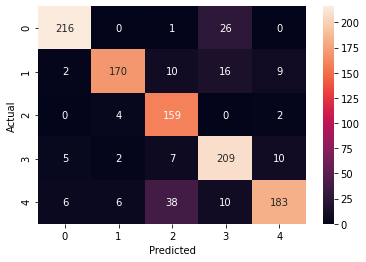


Confusion matrix for test data, when covariance matrix is 0:


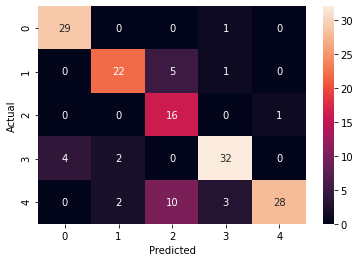

Accuracy on training data, when covariance matrix is 0 : 85.88450962419797%

Accuracy on validation data, when covariance matrix is 0 : 77.07006369426752%

Accuracy on test data, when covariance matrix is 0 : 81.41025641025641%



Confusion matrix for training data, when covariance matrix is 1:


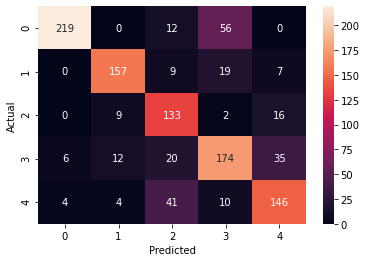


Confusion matrix for test data, when covariance matrix is 1:


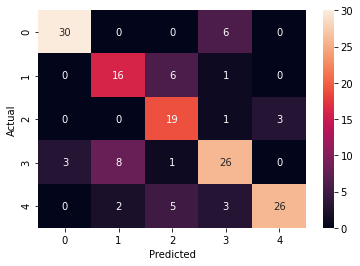

Accuracy on training data, when covariance matrix is 1 : 75.9853345554537%

Accuracy on validation data, when covariance matrix is 1 : 73.24840764331209%

Accuracy on test data, when covariance matrix is 1 : 75.0%




In [16]:
# no. of clusters in a GMM model
Q=13

# getting parameters for classification
w,mean,cov,p_class = getParameters(feature_train,class_train,Q)

# array to store the classification accuracies for each of the datasets
accuracy_dev = np.zeros(2)
accuracy_train = np.zeros(2)
accuracy_test = np.zeros(2)

for i in range(2):
    if(i==0):
        covariance = "full"
    else:
        covariance = "diagonalised"
    confusion_matrix = BayesClassifier(feature_train,class_train,Q,w,mean,cov,p_class,i)
    print("\nConfusion matrix for training data, when covariance matrix is "+covariance+":")
    printheatmap(confusion_matrix)
    accuracy_train[i] = np.trace(confusion_matrix)/len(feature_train)*100
    confusion_matrix = BayesClassifier(feature_dev,class_dev,Q,w,mean,cov,p_class,i)
    accuracy_dev[i] = np.trace(confusion_matrix)/len(feature_dev)*100
    confusion_matrix = BayesClassifier(feature_test,class_test,Q,w,mean,cov,p_class,i)
    accuracy_test[i] = np.trace(confusion_matrix)/len(feature_test)*100
    print("\nConfusion matrix for test data, when covariance matrix is "+covariance+":")
    printheatmap(confusion_matrix)

    print("Accuracy on training data, when covariance matrix is "+covariance+" : "+str(accuracy_train[i])+"%\n")
    print("Accuracy on validation data, when covariance matrix is "+covariance+" : "+str(accuracy_dev[i])+"%\n")
    print("Accuracy on test data, when covariance matrix is "+covariance+" : "+str(accuracy_test[i])+"%\n\n")